In [1]:
#Ideas
#Track down the incorrect predictions and see where they are in the distribition of the rest of the data
#Make sure the weight initialization is random each time
#Can you somehow control the weight initialization to make sure its in a small range?

In [1]:
#HYPERPARAMETERS:
#-Activation function
#-Weight initialisation
#-Loss function
#-Training Algorithms
#-Training Algorithm parameters
#-Learning rate

In [2]:
#Previous Configurations

#Model 1
# model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

# learning_rate = 0.01
# criterion = nn.MSELoss()
# # criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import random
import copy

In [4]:
with open('almonds_prep.pickle','rb') as file:
    All = pickle.load(file)

In [5]:
def myMSE(pred,true):
    return ((pred-true)**2).mean()

def CELoss(pred,true):
    n_samples = pred.shape[0] #Number of training examples
    n_outputs = pred.shape[1] #Number of outputs
    predd = pred + 1e-16
    log_term = torch.log(predd)
    ans = (true*log_term).sum()/(n_samples*n_outputs)
    
    return ans

def convert(yout):
    y_out = copy.deepcopy(yout)
    for h in range(y_out.shape[0]):
        y_out[h][y_out[h] == y_out[h].max()] = 1
        y_out[h][y_out[h] != y_out[h].max()] = 0
    return y_out

def data_shuffler(X,Y,Y_binary):
    idxs = np.arange(0,len(X))
    random.shuffle(idxs)
    
    X_new = X[idxs]
    Y_new = Y[idxs]
    Y_binary_new = Y_binary[idxs]
    return X_new,Y_new,Y_binary_new

def batch_maker(X,Y,Y_binary,num_batches): #X,Y-> shuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/num_batches))
#     print(div)
    
    if num_batches == 1:
        return X,Y,Y_binary
    cnt1 = 0
    cnt2 = div
    Xbatch = []
    Ybatch = []
    Y_binary_batch = []
    for i in range(num_batches-1):
        
        Xbatch.append(X[cnt1:cnt2,:])
        Ybatch.append(Y[cnt1:cnt2])
        Y_binary_batch.append(Y_binary[cnt1:cnt2,:])

        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xbatch.append(X[cnt1:,:])
    Ybatch.append(Y[cnt1:])
    Y_binary_batch.append(Y_binary[cnt1:,:])

    return Xbatch,Ybatch,Y_binary_batch

def accuracy_calc(ytrain_pred, ytrain_target, ytest_pred, ytest_target):
    
    cnt_train = 0

    for h in range(len(ytrain_pred)):
        if sum(ytrain_pred[h,:] == ytrain_target[h,:]) < ytrain_target.shape[1]:
            cnt_train = cnt_train + 1
    incorr_pred_train = cnt_train

    cnt_test = 0
    for j in range(len(ytest_pred)):
        if sum(ytest_pred[j,:] == ytest_target[j,:]) < ytest_target.shape[1]:
            cnt_test = cnt_test + 1
    incorr_pred_test = cnt_test
    return incorr_pred_train, incorr_pred_test

In [6]:
class myNN(nn.Module):
    
    def __init__(self,n_input_features,n_output_features,n_layers_neurons):
        """
        n_input_features = Number of input features
        n_output_features = Number of output features
        n_layers_neurons = Dictionary of HIDDEN layer number and number of neurons in layer
           e.g.  3 hidden layers with 4, 2, and 7 neurons, respectively==> {1:4, 2: 2, 3: 7}
        
        """
        
        super().__init__()
        self.n_hidden_layers = len(list(n_layers_neurons)) #number of hidden layers
        #Creating all the layers
        
        self.layers = nn.ModuleList([nn.Linear(in_features = n_input_features, out_features = n_layers_neurons[1])])#First hidden layer
        
        for n in range(len(n_layers_neurons)-1):
            
            #All hidden layers
            self.layers.append(nn.Linear(in_features = n_layers_neurons[n+1], out_features = n_layers_neurons[n+2]))
            
        self.layers.append(nn.Linear(in_features = n_layers_neurons[list(n_layers_neurons)[-1]], out_features = n_output_features)) #Output layer

        
    def forward(self,x):
        
        #Hidden layers
        ys = []
        ys.append(nn.Tanh()(self.layers[0](x)))
#         print('First layer:',ys)
        for i in range(self.n_hidden_layers - 1):
#             print(i)
            net = self.layers[i+1](ys[i])
            ys.append(nn.Tanh()(net)) #Hidden layers
        
        net_output = self.layers[-1](ys[-1])
        output =nn. Softmax(dim=1)(net_output)
        return output,net_output

In [7]:
Xnum = np.vstack((All[0],All[1],All[2]))
print(Xnum.shape)

(2803, 13)


In [8]:
#Classes: 'MAMRA = [1,0,0]', 'SANORA = [0,1,0]', 'REGULAR' = [0,0,1]
Ynum = []
n_classes = 3
for n in range(len(Xnum)):
    if Xnum[n,-1] == "MAMRA":
        Ynum.append([1,0,0,0])
        
    elif Xnum[n,-1] == "SANORA":
        Ynum.append([0,1,0,1])
        
    elif Xnum[n,-1] == "REGULAR":
        Ynum.append([0,0,1,2])
        
    else:
        print(f"Error row index: {n}")

Xnum = Xnum[:,:-1]
Ynum = np.array(Ynum)
print(f"Input shape: {Xnum.shape}")
print(f"Output shape: {Ynum.shape}")

Input shape: (2803, 12)
Output shape: (2803, 4)


In [9]:
Xnum_train,Xnum_test,Ynum_train,Ynum_test = train_test_split(Xnum,Ynum,test_size = 0.3)
print("X train: ", Xnum_train.shape)
print("X test: ", Xnum_test.shape)
print("Y train: ", Ynum_train.shape)
print("Y test: ", Ynum_test.shape)
Y_binary_train_ = Ynum_train[:,0:-1]
Y_binary_test_ = Ynum_test[:,0:-1]

Ynum_train = Ynum_train[:,-1]
Ynum_test = Ynum_test[:,-1]

X train:  (1962, 12)
X test:  (841, 12)
Y train:  (1962, 4)
Y test:  (841, 4)


In [10]:
xdata_sc = StandardScaler()
Xnum_train = xdata_sc.fit_transform(Xnum_train)
Xnum_test = xdata_sc.transform(Xnum_test)

X_train_ = torch.tensor(Xnum_train.astype(np.float32))
Y_train_ = torch.tensor(Ynum_train,dtype=torch.long)
Y_binary_train_ = torch.tensor(Y_binary_train_.astype(np.float32))

X_test_ = torch.tensor(Xnum_test.astype(np.float32))
Y_test_ = torch.tensor(Ynum_test,dtype=torch.long)
Y_binary_test_ = torch.tensor(Y_binary_test_.astype(np.float32))

In [12]:
def hybrid_model(X_train_unshuff,X_test,Y_train_unshuff,Y_binary_train_unshuff,Y_test,Y_binary_test,lr_sgd,momentum,lr_adam,nlow,nhigh,a,b,c):
    
    model_sgd = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})
    model_adam = copy.deepcopy(model_sgd)
    model_rprop = copy.deepcopy(model_sgd)

    sgd_theta = 1 #Contribution of each training algorithm
    adam_theta = 1
    rprop_theta = 1

    criterion = nn.CrossEntropyLoss(reduction = 'none')
    optimizer_sgd = torch.optim.SGD(model_sgd.parameters(),lr = lr_sgd,momentum = momentum)
    optimizer_adam = torch.optim.Adam(model_adam.parameters(),lr = lr_adam)
    optimizer_rprop = torch.optim.Rprop(model_rprop.parameters(),etas = (nlow,nhigh))

    losses_train_sgd = [] #Stores training losses at each epoch
    losses_test_sgd = [] #Stores testing losses at each epoch
    
    accuracy_train = []
    accuracy_test = []

    num_batches = 1 #Number of training batches

    sgd_step_store = []
    adam_step_store = []
    rprop_step_store = []
    avg_step_store = []


    max_num_epochs = 500
    num_epochs = 0
    error = 100
    tol = 8e-3

    while (error > tol) and (num_epochs < max_num_epochs):

        num_epochs+= 1

        X_train,Y_train,Y_binary_train = data_shuffler(X_train_unshuff,Y_train_unshuff,Y_binary_train_unshuff)
        Xbatches, Ybatches, YBinaryBatches = batch_maker(X_train,Y_train,Y_binary_train,num_batches)

        X_train_batch = Xbatches
        Y_train_batch = Ybatches
        Y_train_binary_batch = YBinaryBatches

        #Forward pass
        ypred_train_sgd,output_net_sgd = model_sgd(X_train_batch)
        ypred_train_adam,output_net_adam = model_adam(X_train_batch)
        ypred_train_rprop,output_net_rprop = model_rprop(X_train_batch)

        #Compute loss
        loss_train_sgd = criterion(output_net_sgd,Y_train_batch).sum()/(n_classes*len(Y_train_batch))
        loss_train_adam = criterion(output_net_adam,Y_train_batch).sum()/(n_classes*len(Y_train_batch))
        loss_train_rprop = criterion(output_net_rprop,Y_train_batch).sum()/(n_classes*len(Y_train_batch))

        #Backward pass
        loss_train_sgd.backward()
        loss_train_adam.backward()
        loss_train_rprop.backward()

        #Hybrid Learning Implementation
        #Save the previous step
        wt_state_sgd = copy.deepcopy(model_sgd.state_dict())
        wt_state_adam = copy.deepcopy(model_adam.state_dict())
        wt_state_rprop = copy.deepcopy(model_rprop.state_dict())

        #Update weights
        optimizer_sgd.step()
        optimizer_adam.step()
        optimizer_rprop.step()

        #Save the current step
        wt1_state_sgd = copy.deepcopy(model_sgd.state_dict())
        wt1_state_adam = copy.deepcopy(model_adam.state_dict())
        wt1_state_rprop = copy.deepcopy(model_rprop.state_dict())

        sgd_step_store_net = []
        adam_step_store_net = []
        rprop_step_store_net = []
        avg_step_store_net = []

        for sgd_wt1,adam_wt1,rprop_wt1 in zip(model_sgd.named_parameters(),model_adam.named_parameters(),model_rprop.named_parameters()):

            #Compute weight update/ step size-->Current step minus previous step
            sgd_step = wt1_state_sgd[sgd_wt1[0]].clone().detach() - wt_state_sgd[sgd_wt1[0]].clone().detach()
            adam_step = wt1_state_adam[adam_wt1[0]].clone().detach() - wt_state_adam[adam_wt1[0]].clone().detach()
            rprop_step = wt1_state_rprop[rprop_wt1[0]] - wt_state_rprop[rprop_wt1[0]].clone().detach()

            sgd_step_store_net.append(sgd_step)
            adam_step_store_net.append(adam_step)
            rprop_step_store_net.append(rprop_step)

            #combine the step sizes
            avg_step = a*sgd_step + b*adam_step + c*rprop_step

            wt_state_sgd[sgd_wt1[0]] += avg_step #add the average step to the old state

            wt_state_adam[adam_wt1[0]] += avg_step #add the average step to the old state

            wt_state_rprop[rprop_wt1[0]] += avg_step #add the average step to the old state

            model_sgd.load_state_dict(wt_state_sgd) #update
            model_adam.load_state_dict(wt_state_adam) #update
            model_rprop.load_state_dict(wt_state_rprop) #update
            
            avg_step_store_net.append(avg_step)

        sgd_step_store.append(sgd_step_store_net)
        adam_step_store.append(adam_step_store_net)
        rprop_step_store.append(rprop_step_store_net)
        avg_step_store.append(avg_step_store_net)

        optimizer_sgd.zero_grad()
        optimizer_adam.zero_grad()
        optimizer_rprop.zero_grad()

        with torch.no_grad():

        #Forward pass using entire dataset
            ypred_train_epoch_sgd,output_net_train_epoch_sgd = model_sgd(X_train)
            ypred_test_epoch_sgd,output_net_test_epoch_sgd = model_sgd(X_test)

            loss_train_epoch_sgd = criterion(output_net_train_epoch_sgd,Y_train).sum()/(n_classes*len(Y_train))
            losses_train_sgd.append(loss_train_epoch_sgd)

            loss_test_epoch_sgd = criterion(output_net_test_epoch_sgd,Y_test).sum()/(n_classes*len(Y_test))
            losses_test_sgd.append(loss_test_epoch_sgd)

        #Accuracy Calculation
        Ypred_train_epoch = convert(ypred_train_epoch_sgd)
        Ypred_test_epoch = convert(ypred_test_epoch_sgd)

        cnt_train,cnt_test = accuracy_calc(Ypred_train_epoch, Y_binary_train, Ypred_test_epoch, Y_binary_test)
        accuracy_train.append(100-(cnt_train/len(Ypred_train_epoch)*100))
        accuracy_test.append(100-(cnt_test/len(Ypred_test_epoch)*100))
            
        error = ((ypred_train_epoch_sgd - Y_binary_train)**2).mean()

        print(f"Epoch {num_epochs} Done ============================================")
        print(" Epoch Training Loss: ",loss_train_epoch_sgd)
        print("Epoch Testing Loss: ",loss_test_epoch_sgd)
        print(" Epoch Training Accuracy: ",100-(cnt_train/len(Ypred_train_epoch)*100))
        print("Epoch Testing Accuracy: ",100-(cnt_test/len(Ypred_test_epoch)*100))
        print("Epoch Error:", error)


    losses_train_sgd = torch.tensor(losses_train_sgd)
    losses_test_sgd = torch.tensor(losses_test_sgd)
    
    accuracy_train = torch.tensor(accuracy_train)
    accuracy_test = torch.tensor(accuracy_test)
    
    return {"LossTrain":losses_train_sgd,
            "LossTest":losses_test_sgd,
            "AccTrain":accuracy_train,
            "AccTest":accuracy_test,
           "NumEpochs": num_epochs,
           "SGDWeightUpdates":sgd_step_store,
           "AdamWeightUpdates":adam_step_store,
           "RproprWeightUpdates":rprop_step_store,
           "AvgWeightUpdates":avg_step_store}

In [13]:
ans =  hybrid_model(X_train_,X_test_,Y_train_,Y_binary_train_,Y_test_,Y_binary_test_,lr_sgd = 1.0,momentum = 0.5,lr_adam = 0.019,nlow = 0.9,nhigh = 1.2,a = 1/3,b = 1/3, c = 1/3)


Epoch 1 Done ============================================
 Epoch Training Loss:  tensor(0.3926)
Epoch Testing Loss:  tensor(0.3857)
 Epoch Training Accuracy:  32.67074413863405
Epoch Testing Accuracy:  34.720570749108205
Epoch Error: tensor(0.2412)
Epoch 2 Done ============================================
 Epoch Training Loss:  tensor(0.3739)
Epoch Testing Loss:  tensor(0.3681)
 Epoch Training Accuracy:  32.67074413863405
Epoch Testing Accuracy:  34.720570749108205
Epoch Error: tensor(0.2273)
Epoch 3 Done ============================================
 Epoch Training Loss:  tensor(0.3560)
Epoch Testing Loss:  tensor(0.3510)
 Epoch Training Accuracy:  32.7217125382263
Epoch Testing Accuracy:  34.720570749108205
Epoch Error: tensor(0.2143)
Epoch 4 Done ============================================
 Epoch Training Loss:  tensor(0.3363)
Epoch Testing Loss:  tensor(0.3311)
 Epoch Training Accuracy:  61.31498470948012
Epoch Testing Accuracy:  63.8525564803805
Epoch Error: tensor(0.2007)
Epoch 5

Epoch 34 Done ============================================
 Epoch Training Loss:  tensor(0.1185)
Epoch Testing Loss:  tensor(0.1065)
 Epoch Training Accuracy:  86.69724770642202
Epoch Testing Accuracy:  87.63376932223544
Epoch Error: tensor(0.0654)
Epoch 35 Done ============================================
 Epoch Training Loss:  tensor(0.1224)
Epoch Testing Loss:  tensor(0.1113)
 Epoch Training Accuracy:  85.16819571865443
Epoch Testing Accuracy:  86.56361474435197
Epoch Error: tensor(0.0688)
Epoch 36 Done ============================================
 Epoch Training Loss:  tensor(0.1185)
Epoch Testing Loss:  tensor(0.1050)
 Epoch Training Accuracy:  85.37206931702345
Epoch Testing Accuracy:  86.56361474435197
Epoch Error: tensor(0.0666)
Epoch 37 Done ============================================
 Epoch Training Loss:  tensor(0.1063)
Epoch Testing Loss:  tensor(0.0946)
 Epoch Training Accuracy:  86.54434250764527
Epoch Testing Accuracy:  87.99048751486326
Epoch Error: tensor(0.0591)
Epoc

Epoch 67 Done ============================================
 Epoch Training Loss:  tensor(0.0475)
Epoch Testing Loss:  tensor(0.0466)
 Epoch Training Accuracy:  95.10703363914374
Epoch Testing Accuracy:  94.53032104637336
Epoch Error: tensor(0.0258)
Epoch 68 Done ============================================
 Epoch Training Loss:  tensor(0.0598)
Epoch Testing Loss:  tensor(0.0552)
 Epoch Training Accuracy:  92.40570846075433
Epoch Testing Accuracy:  93.46016646848989
Epoch Error: tensor(0.0357)
Epoch 69 Done ============================================
 Epoch Training Loss:  tensor(0.0506)
Epoch Testing Loss:  tensor(0.0453)
 Epoch Training Accuracy:  92.91539245667686
Epoch Testing Accuracy:  93.22235434007135
Epoch Error: tensor(0.0303)
Epoch 70 Done ============================================
 Epoch Training Loss:  tensor(0.0357)
Epoch Testing Loss:  tensor(0.0342)
 Epoch Training Accuracy:  95.71865443425077
Epoch Testing Accuracy:  96.6706302021403
Epoch Error: tensor(0.0197)
Epoch

<IPython.core.display.Javascript object>


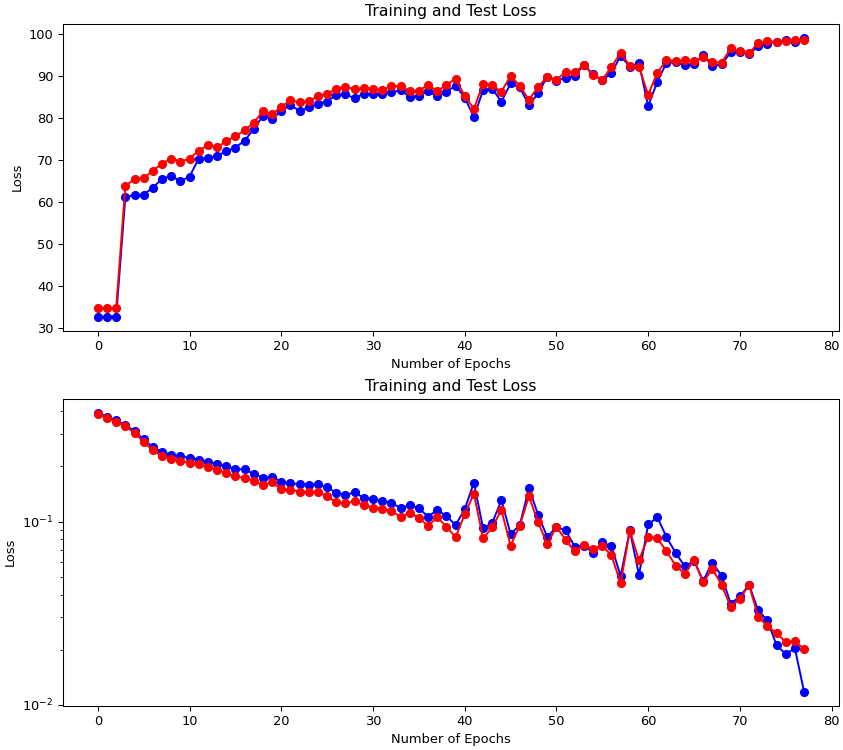

AttributeError: 'numpy.ndarray' object has no attribute 'legend'

In [17]:
%matplotlib notebook
fig, ax = plt.subplots(2,1,figsize = (9,8),layout = 'constrained')


ax[0].plot(np.arange(0,ans['NumEpochs']),ans['AccTrain'],marker = 'o',color='b',label = "Training Accuracy")
ax[0].set_title("Training and Test Loss")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Loss")
ax[0].plot(np.arange(0,ans['NumEpochs']),ans["AccTest"],marker = 'o',color='r',label = "Test Accuracy")

ax[1].set_yscale("log")

ax[1].plot(np.arange(0,ans['NumEpochs']),ans['LossTrain'],marker = 'o',color='b',label = "Training Loss")
ax[1].set_title("Training and Test Loss")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(np.arange(0,ans['NumEpochs']),ans["LossTest"],marker = 'o',color='r',label = "Test Loss")



ax.legend()

In [18]:
ans["AccTest"][-1]

tensor(98.6920)